<a href="https://colab.research.google.com/github/mtsizh/galaxy-morphology-manifold-learning/blob/main/find_best_reduction_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you performed dataset curation on your own - upload `curated_imgs.zip` and skip to the next step. Otherwise you can run the following code and download the curated dataseet from GitHub.

In [6]:
!wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.zip && echo "HEAD dowloaded" || "ERROR downloading HEAD"

for i in range(1,8):
  !wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.z0{i}  && echo "PART {i} of 7 OK" || "ERROR downloading PART {i}"

print('MERGING PARTS')
!zip -FF curated_imgs_multipart.zip --out curated_imgs.zip > /dev/null && rm curated_imgs_multipart.z* && echo "COMPLETE" || "FAILED"


HEAD dowloaded
PART 1 of 7 OK
PART 2 of 7 OK
PART 3 of 7 OK
PART 4 of 7 OK
PART 5 of 7 OK
PART 6 of 7 OK
PART 7 of 7 OK
MERGING PARTS
COMPLETE


Unzip the curated dataset.

In [7]:
!unzip -q -o curated_imgs.zip && echo "UNZIPPED" || "FAIL"

UNZIPPED


Few libraries are not installed by default. the following code installs `optuna` and `umap-learn`.

In [4]:
!pip install optuna
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

try:
  import optuna
  from cuml.manifold import TSNE
  from cuml.manifold import UMAP
  from cuml.decomposition import PCA
  from google.colab import output
  output.clear()
except:
  print('ERROR')
finally:
  print('COMPLETE')

COMPLETE


Run the following code to generate a report on different methods. `optuna` is used to get the best parameters for each of the methods: t-SNE, uMap, IsoMap, LLE, PCA. Result is saved in form of a `json` file. See variable `reports_folder` for path.

|File|Purpose|
|---|---|
|`results.json`|Best parameters for each method|
`log_intermediate_results.json`|All results tested by `optuna` library|
|images.np|Images to use the same batch for all methods even after runtime disconnection|

**Warning** Colab may periodically turn off the virtual machine. To avoid data loss after each dimensionality reduction method is processed results are stored to json files. If these files are present on the next run, methods already fully processed are skipped. For more data safety you may want to set `reports_folder` to Google Drive path so that it is not deleted if the runtime is removed.

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import json
import pprint
import cupy as cp
from cuml.manifold import TSNE
from cuml.manifold import UMAP
from cuml.decomposition import PCA
import warnings
from sklearn.manifold import LocallyLinearEmbedding, Isomap
import os.path


# use different class maps to get different estimations
class_map = {1: 'round', 2: 'inbetween', 3: 'cigar'}
#class_map = {4: 'edge on', 5: 'edge off'}
#class_map = {6: 'smooth', 7: 'featured'}
methods = ['t-SNE', 'uMap', 'LLE', 'Isomap', 'PCA']
n_bootstrap_samples = 5000
n_parameter_trials = 50
reports_folder = '.' #'./drive/MyDrive'
best_resuts_file = os.path.join(reports_folder, 'results.json')
all_results_file = os.path.join(reports_folder, 'log_intermediate_results.json')
images_arr_file = os.path.join(reports_folder, 'images.npy')
classes_arr_file = os.path.join(reports_folder, 'classes.npy')


def load_images():
  df = pd.read_parquet('curated_dataset.parquet')
  regex_filter = '|'.join(class_map.values())
  filtered_df = df[df['class'].str.contains(regex_filter, regex=True)]
  bootstrapped_df = filtered_df.sample(n=n_bootstrap_samples, random_state=25)
  X = np.zeros((len(bootstrapped_df), 120, 120))
  y = np.zeros(len(bootstrapped_df))

  for key, val in class_map.items():
    y[bootstrapped_df['class'].str.contains(val, regex=True)] = key

  print('Dataset balance:')
  for k,v in class_map.items():
    print(f'class {v} has {np.sum(y == k)} items')
  print('-----------------------------------------')

  print('LOAD IMAGES')
  paths = bootstrapped_df['png_loc'].str.replace('dr5', 'curated_imgs')
  with tqdm(total=len(paths)) as progress:
    for idx, file_path in enumerate(paths):
      with Image.open(file_path) as img:
        X[idx,:,:] = np.array(img)
        progress.update()
  np.save(images_arr_file, X)
  np.save(classes_arr_file, y)
  return X, y


if os.path.isfile(images_arr_file) and os.path.isfile(classes_arr_file):
  X = np.load(images_arr_file)
  y = np.load(classes_arr_file)
else:
  X, y = load_images()

X_flattened = X.reshape(X.shape[0], -1)

# load previously calculated results if present
log_intermediate_results = []
result = []
if (os.path.isfile(best_resuts_file) and
    os.path.isfile(all_results_file)):
  with open(best_resuts_file) as json_file:
    result = json.load(json_file)
  with open(all_results_file) as json_file:
    log_intermediate_results = json.load(json_file)


def objective(trial, methods):
  global log_intermediate_results
  dr_method = trial.suggest_categorical('dr_method', methods)

  if dr_method == 't-SNE':
    n_components = 2 # cuml supports only 2 components, sklearn tsne works 3 days
    perplexity = trial.suggest_int('perplexity', 5, min(50, X.shape[0]-1)) # perplexity < samples
    n_neighbors = trial.suggest_int('n_neighbors', 3*(perplexity+1), max(3*(perplexity+1), min(50, X.shape[0]-1)))
    reducer = TSNE(n_components=n_components, perplexity=perplexity,
                   method='fft', n_neighbors=n_neighbors)
    log_intermediate_results.append({'dr_method': 't-SNE', 'perplexity': perplexity, 'n_neighbors': n_neighbors})
  elif dr_method == 'LLE':
    n_components = trial.suggest_int('n_components', 2, min(200, X.shape[0]-1)) # components < samples
    n_neighbors = trial.suggest_int('n_neighbors', min(2, n_components),
                                    max(50, n_components)) # neighbors <= samples
    reducer = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors, n_jobs=-1)
    log_intermediate_results.append({'dr_method': 'LLE', 'n_components': n_components, 'n_neighbors': n_neighbors})
  elif dr_method == 'Isomap':
    n_components = trial.suggest_int('n_components', 2, min(200, X.shape[0]-1)) # components < samples
    n_neighbors = trial.suggest_int('n_neighbors', 10, min(50, X.shape[0]//2))
    reducer = Isomap(n_components=n_components, n_neighbors=n_neighbors, n_jobs=-1)
    log_intermediate_results.append({'dr_method': 'Isomap', 'n_components': n_components, 'n_neighbors': n_neighbors})
  elif dr_method == 'PCA':
    n_components = trial.suggest_int('n_components', 2, np.min([200, X.shape[0]-1, X.shape[1]-1]))
    reducer = PCA(n_components=n_components, svd_solver='full')
    log_intermediate_results.append({'dr_method': 'PCA', 'n_components': n_components})
  elif dr_method == 'uMap':
    n_components = trial.suggest_int('n_components', 2, np.min([200, X.shape[0]//2, X.shape[1]-1]))
    n_neighbors = trial.suggest_int('n_neighbors', 5, min(50, X.shape[0]-1)) # neighbors < samples
    reducer = UMAP(n_neighbors=n_neighbors, n_components=n_components)
    log_intermediate_results.append({'dr_method': 'UMAP', 'n_components': n_components, 'n_neighbors': n_neighbors})

  try: #ISOMAP fails without any reason
    X_reduced = reducer.fit_transform(X_flattened)
  except ValueError as e:
    print(f"Skipping {method} trial due to error: {e}")
    log_intermediate_results = log_intermediate_results[:-1]
    return -np.inf # not to spoil the result

  clf = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42))
  quality = np.mean(cross_val_score(clf, X_reduced, y, cv=5))
  log_intermediate_results[-1]['quality'] = quality

  return quality

# ignore annoying futurewarnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*default method of TSNE.*", category=UserWarning)

methods_processed = [x['dr_method'] for x in result]
for method in methods:
  print(f'********************************{method}***************************')
  if method in methods_processed:
    print('Already present in JSON file as processed, skipping')
    continue
  study = optuna.create_study(direction="maximize")
  study.optimize(lambda T: objective(T, [method]),
                n_trials=n_parameter_trials, show_progress_bar=True, n_jobs=1)
  print("Best parameters:", study.best_params, "Best value:", study.best_value)
  result.append(study.best_params)
  result[-1]['best_value'] = study.best_value

  pretty_json_str = pprint.pformat(result, compact=True).replace("'",'"')
  with open(best_resuts_file, "w") as outfile:
      outfile.write(pretty_json_str)

  pretty_json_str = pprint.pformat(log_intermediate_results, compact=True).replace("'",'"')
  with open(all_results_file, "w") as outfile:
      outfile.write(pretty_json_str)

If processing takes too long you can download our results.

In [1]:
!wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/best_parameters/log_results.zip && echo "HEAD dowloaded" || "ERROR downloading HEAD"
!unzip -q -o log_results.zip && echo "UNZIPPED" || "FAIL"

HEAD dowloaded
UNZIPPED


Generate representations for different methods and classes.

In [15]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import json
import pprint
import cupy as cp
from cuml.manifold import TSNE
from cuml.manifold import UMAP
from cuml.decomposition import PCA
import warnings
from sklearn.manifold import LocallyLinearEmbedding, Isomap
import os.path
import pickle
import locale
locale.getpreferredencoding = lambda: "UTF-8"



reports_folder = '.' #'./drive/MyDrive'
best_resuts_file = os.path.join(reports_folder, 'results.json')
all_results_file = os.path.join(reports_folder, 'log_intermediate_results.json')
images_arr_file = os.path.join(reports_folder, 'images.npy')
classes_arr_file = os.path.join(reports_folder, 'classes.npy')

class_map = {1: 'round', 2: 'inbetween', 3: 'cigar'}
#class_map = {4: 'edge on', 5: 'edge off'}
#class_map = {6: 'smooth', 7: 'featured'}
n_bootstrap_samples = 10000


def load_images():
  df = pd.read_parquet('curated_dataset.parquet')
  regex_filter = '|'.join(class_map.values())
  filtered_df = df[df['class'].str.contains(regex_filter, regex=True)]
  bootstrapped_df = filtered_df.sample(n=n_bootstrap_samples, random_state=25)
  X = np.zeros((len(bootstrapped_df), 120, 120))
  y = np.zeros(len(bootstrapped_df))

  for key, val in class_map.items():
    y[bootstrapped_df['class'].str.contains(val, regex=True)] = key

  print('Dataset balance:')
  for k,v in class_map.items():
    print(f'class {v} has {np.sum(y == k)} items')
  print('-----------------------------------------')

  print('LOAD IMAGES')
  paths = bootstrapped_df['png_loc'].str.replace('dr5', 'curated_imgs')
  with tqdm(total=len(paths)) as progress:
    for idx, file_path in enumerate(paths):
      with Image.open(file_path) as img:
        X[idx,:,:] = np.array(img)
        progress.update()
  return X, y


if os.path.isfile(images_arr_file) and os.path.isfile(classes_arr_file):
  X = np.load(images_arr_file)
  y = np.load(classes_arr_file)
else:
  X, y = load_images()
  np.save(images_arr_file, X)
  np.save(classes_arr_file, y)

X_flattened = X.reshape(X.shape[0], -1)

with open(best_resuts_file, 'r') as f_in:
  best_dict = json.load(f_in)
print('***************** BEST PARAMETERS ***************************')
print(pd.DataFrame(best_dict))

methods = {
    't-SNE': lambda x: TSNE(n_components=2,
                            perplexity=x['perplexity'],
                            method='fft', n_neighbors=x['n_neighbors']),
    'LLE': lambda x: LocallyLinearEmbedding(n_components=x['n_components'],
                                            n_neighbors=x['n_neighbors'],
                                            n_jobs=-1),
    'Isomap': lambda x: Isomap(n_components=x['n_components'],
                               n_neighbors=x['n_neighbors'], n_jobs=-1),
    'PCA': lambda x: PCA(n_components=x['n_components'], svd_solver='full'),
    'uMap': lambda x: UMAP(n_neighbors=x['n_neighbors'],
                           n_components=x['n_components'])
}
filenames = {
    't-SNE': lambda x: f"tSNE_dim_2_neigh_{x['n_neighbors']}_perp_{x['perplexity']}.pkl",
    'LLE': lambda x: f"LLE_dim_{x['n_components']}_neigh_{x['n_neighbors']}.pkl",
    'Isomap': lambda x: f"ISO_dim_{x['n_components']}_neigh_{x['n_neighbors']}.pkl",
    'PCA': lambda x: f"PCA_dim_{x['n_components']}.pkl",
    'uMap': lambda x: f"UMAP_dim_{x['n_components']}_neigh_{x['n_neighbors']}.pkl"
}

for elem in best_dict:
  filename = filenames[elem['dr_method']](elem)
  print(f"***************** {elem['dr_method']} ***********************")
  if os.path.isfile(filename):
    print(f'FILE {filename} already exists, skip calculations')
    continue
  method = methods[elem['dr_method']](elem)
  X_embedded = method.fit_transform(X_flattened)
  print('SAVING to: ', filename)
  with open(filename, 'wb') as f:
    pickle.dump({'X_embedded': X_embedded, 'y': y,
                 'class_map': class_map,
                 'parameters': elem}, f)
  print(f'DUMPED {filename}')


print('ZIPPING just in case')
!zip -q -r pikle_files.zip *.pkl && echo "zipped" || echo "zip error"
print('COMPLETE')

Dataset balance:
class round has 3300 items
class inbetween has 5029 items
class cigar has 1671 items
-----------------------------------------
LOAD IMAGES


  0%|          | 0/10000 [00:00<?, ?it/s]

***************** BEST PARAMETERS ***************************
   best_value dr_method  n_components  n_neighbors  perplexity
0      0.9344       LLE         138.0         10.0         NaN
1      0.8760    Isomap          87.0         10.0         NaN
2      0.9160      uMap          82.0         26.0         NaN
3      0.5426     t-SNE           NaN        102.0        33.0
4      0.6078       PCA          63.0          NaN         NaN
***************** LLE ***********************
SAVING to:  LLE_dim_138_neigh_10.pkl
DUMPED LLE_dim_138_neigh_10.pkl
***************** Isomap ***********************
SAVING to:  ISO_dim_87_neigh_10.pkl
DUMPED ISO_dim_87_neigh_10.pkl
***************** uMap ***********************
SAVING to:  UMAP_dim_82_neigh_26.pkl
DUMPED UMAP_dim_82_neigh_26.pkl
***************** t-SNE ***********************


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [20:09:44.707756] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
SAVING to:  tSNE_dim_2_neigh_102_perp_33.pkl
DUMPED tSNE_dim_2_neigh_102_perp_33.pkl
***************** PCA ***********************
SAVING to:  PCA_dim_63.pkl
DUMPED PCA_dim_63.pkl
ZIPPING just in case
zipped
COMPLETE


If processing takes too long you can use our results from the repository.

**Warning:** do NOT run the next line of code if you want to process your own files - downloading will overwrite them

In [20]:
!wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/best_parameters/pikle_files.zip && echo "downloaded" || "ERROR"
!unzip -q -o pikle_files.zip && echo "UNZIPPED" || "FAIL"

downloaded
UNZIPPED


Process images with best parameters from `results.json`. Please note that now processing is perfomed on a bigger batch of images, thus results may not perfectly coincide.

processing:  LLE_dim_138_neigh_10.pkl


,best_value,dr_method,n_components,n_neighbors
,0.9344,LLE,138,10


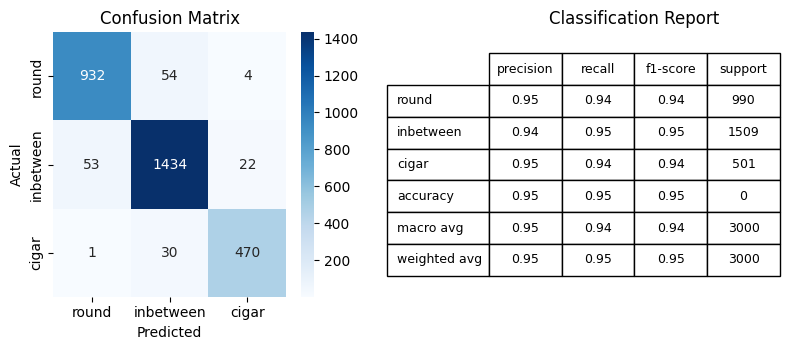

processing:  ISO_dim_87_neigh_10.pkl


,best_value,dr_method,n_components,n_neighbors
,0.876,Isomap,87,10


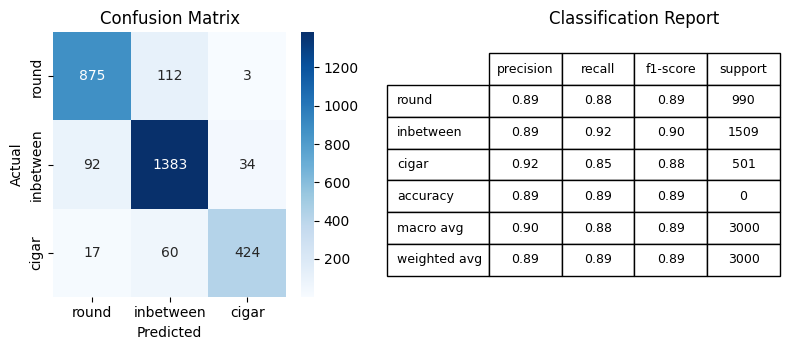

processing:  PCA_dim_63.pkl


,best_value,dr_method,n_components
,0.6078,PCA,63


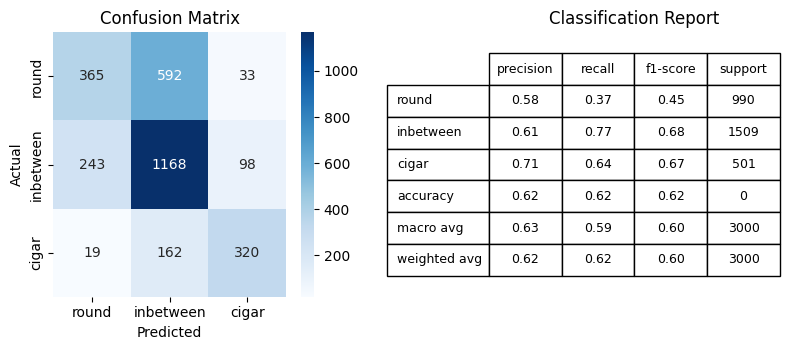

processing:  UMAP_dim_82_neigh_26.pkl


,best_value,dr_method,n_components,n_neighbors
,0.916,uMap,82,26


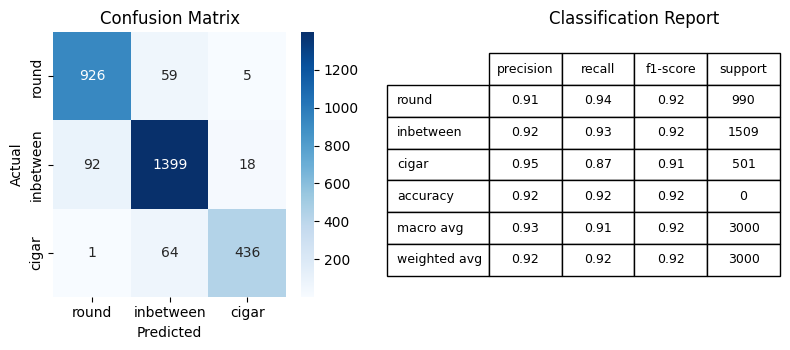

processing:  tSNE_dim_2_neigh_102_perp_33.pkl


,best_value,dr_method,n_neighbors,perplexity
,0.5426,t-SNE,102,33


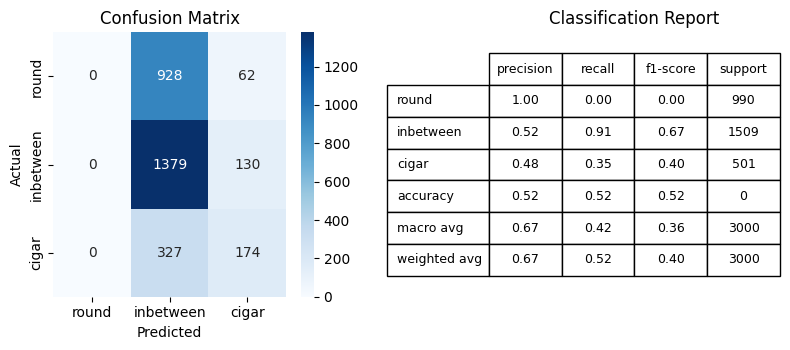

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import glob
from IPython.display import display, HTML



# helper function for visuals
def draw_heatmap_with_info(y_test, y_pred, width, height, clsnames):
    cm = confusion_matrix(y_test, y_pred, labels=list(clsnames.keys()))
    cm_df = pd.DataFrame(cm, index=list(clsnames.values()), columns=list(clsnames.values()))
    cm_arr = cm_df.to_numpy()

    class_report = classification_report(y_test, y_pred, output_dict=True,
                                         target_names=list(clsnames.values()), zero_division=1)
    class_report_df = pd.DataFrame(class_report).transpose()
    class_report_df['support'] = class_report_df['support'].astype(int)

    fig, axes = plt.subplots(1, 2, figsize=(width, height))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")
    axes[1].axis('off')
    table = axes[1].table(
        cellText=class_report_df.map(lambda x: f"{x:.2f}" if isinstance(x, float) else x).values,
        rowLabels=class_report_df.index,
        colLabels=class_report_df.columns,
        cellLoc="center",
        loc="center",
    )
    table.scale(1, 2)
    axes[1].set_title("Classification Report")
    plt.tight_layout()
    plt.show()

def process_file(load_from):
  with open(load_from, 'rb') as f:
    data = pickle.load(f)
    X_embedded = data['X_embedded']
    y = data['y']
    class_map = data['class_map']
    parameters = data['parameters']

  df = pd.DataFrame(parameters, index=[' '])
  display(HTML(df.to_html()))

  # Split dataset into train/test sets
  X_train, X_test, y_train, y_test = train_test_split(X_embedded, y, test_size=0.3, random_state=42, stratify=y)

  # Normalize features
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # Fit multinomial logistic regression
  model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
  model.fit(X_train, y_train)

  # Make predictions
  y_pred = model.predict(X_test)

  # Generate confusion matrix
  draw_heatmap_with_info(y_test, y_pred, width=8, height=3.6, clsnames=class_map)



pkl_files = glob.glob("*.pkl")
for pkl_file in pkl_files:
  print('processing: ', pkl_file)
  process_file(pkl_file)
